In [1]:
import torch
import torch.nn as nn

import numpy as np

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:

def gaussian(x, A, u, s):
    return A * np.exp(-((x - u)/s)**2/2)/(np.sqrt(2*np.pi)*s)

def wrap_gaussian(x, A, u, s):
    in_dis = np.abs(x-u)
    x_dis = np.minimum(in_dis, 1-in_dis)
    return gaussian(x_dis, A, 0, s)

def range_sampling(value_range, size):
    return np.random.random(size = size) * (value_range[1] - value_range[0]) + value_range[0]

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


In [5]:
data_num = 1
n_max = 7
A_range = [0.00, 5.00]
u_range = [0.00, 1.00]
s_range = [0.01, 0.02]

In [6]:
x = np.linspace(0.0, 1.0, 257)[:-1]
As = range_sampling(A_range, (data_num, 1, n_max))
us = range_sampling(u_range, (data_num, 1, n_max))
ss = range_sampling(s_range, (data_num, 1, n_max))

In [7]:
data = np.sum(wrap_gaussian(x.reshape(1, -1, 1), As, us, ss), axis = -1)

In [8]:
def PConv1d(in_channels, out_channels, padding):
    return nn.Sequential(
                            nn.CircularPad1d(padding),
                            nn.Conv1d(in_channels, out_channels, 2*padding+1)
                        )

In [9]:
a = data[0]
b = np.roll(a, 100)

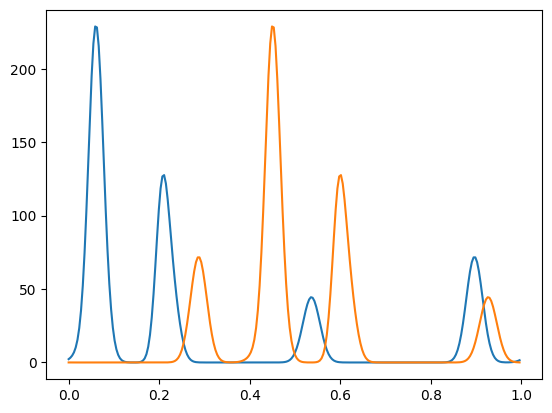

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x, a)
plt.plot(x, b)
plt.show()

In [11]:
conv_layer = PConv1d(1, 1, 5)

In [12]:
conv_layer[1].weight

Parameter containing:
tensor([[[-0.1099,  0.2727, -0.1691,  0.2785,  0.1476, -0.2949,  0.1936,
           0.2847,  0.2564, -0.2248,  0.0673]]], requires_grad=True)

In [13]:
conv_a = conv_layer(torch.from_numpy(a).view(1, 1, -1))
conv_b = conv_layer(torch.from_numpy(b).view(1, 1, -1))

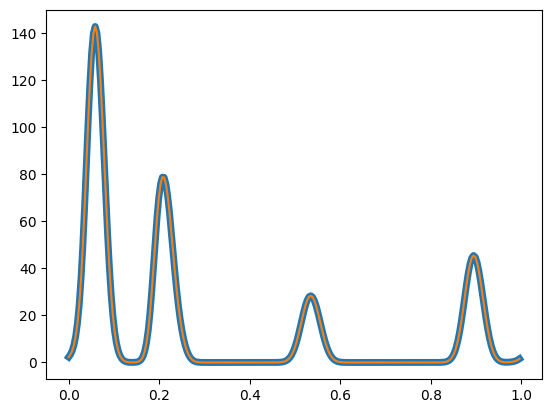

In [20]:
plt.figure()
plt.plot(x, conv_a.detach().numpy().flatten(), linewidth = 5)
plt.plot(x, np.roll(conv_b.detach().numpy().flatten(), -100))
plt.show()

In [42]:
maxpool_layer = nn.MaxPool1d(2, 2)

maxpool_a = maxpool_layer(torch.from_numpy(a).view(1, 1, -1))
maxpool_b = torch.roll(maxpool_layer(torch.from_numpy(np.roll(a, 1)).view(1, 1, -1)), 0)

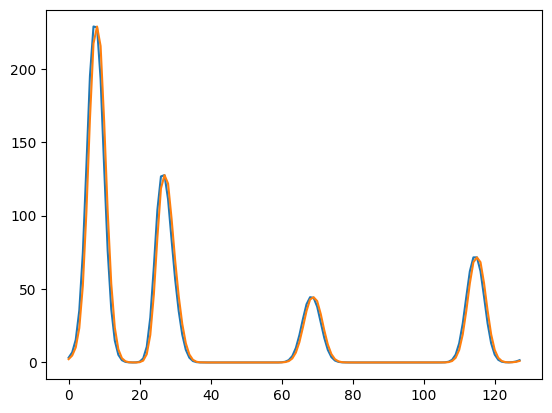

In [43]:
plt.figure()
plt.plot(maxpool_a.detach().numpy().flatten())
plt.plot(maxpool_b.detach().numpy().flatten())
plt.show()

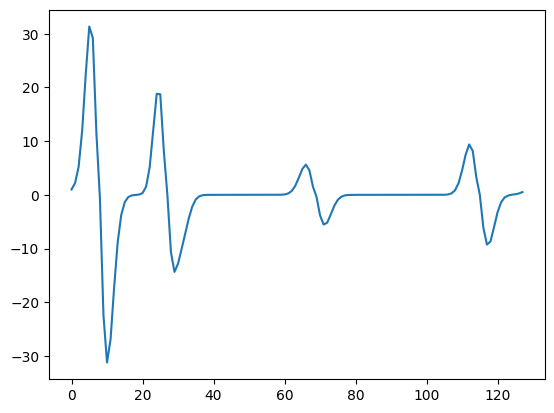

In [44]:
plt.figure()
plt.plot((maxpool_a-maxpool_b).detach().numpy().flatten())
plt.show()